In [1]:
%load_ext autoreload
%autoreload 2

import scipy.io.wavfile as wav
import pyaudio
import wave
import sys
import pyaudio
import scipy
from scipy import signal

import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from numpy import random

from playsound import *
from savetimeseries import *
from combinesignalnoise import *
from combinesignalsignal import *
from plottimeseries import *
from plotsignalnoisetimeseries import *
from plotsignalsignaltimeseries import *
from plotsignalsignalnoisetimeseries import *
from plothistogram import *
from plotpowerspectrum import *

%matplotlib inline

# Routines to generate different types of signals

In [2]:
def puretone(tmin, tmax, f0):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = np.int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)

    y = np.sin(2*np.pi*f0*t) 
    
    return t, y

In [3]:
def whitenoise(tmin, tmax, var):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = np.int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)
    
    y = random.normal(0,var,N)
    
    return t, y

In [4]:
def ringdown(tmin, tmax, A, f0, Q, lambda_poisson):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = np.int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)
    
    if lambda_poisson==0: # special case
        
        t0 = 0.5*(tmin + tmax)
        y = np.zeros(N)
        indices = np.where(t>=t0)[0]
        y[indices[0]-1:-1] = A*np.exp(-2.*np.pi*f0*(t[indices]-t0)/Q)*np.cos(2.*np.pi*f0*(t[indices]-t0))                

    else: # multiple ringdowns
        
        # determine total number of burst to simulate
        Nbursts = random.poisson(lambda_poisson)
    
        # determine random arrival times and amplitudes
        t0 = random.uniform(0, tmax, Nbursts)
        t0 = np.sort(t0)
        AI = random.uniform(A-0.5, A+0.5, Nbursts)
    
        y  = np.zeros(N)    
        for ii in range(0,Nbursts):
            
            indices = np.where(t>=t0[ii])[0]
            
            temp = np.zeros(N)
            temp[indices[0]-1:-1] = AI[ii]*np.exp(-2.*np.pi*f0*(t[indices]-t0[ii])/Q)*np.cos(2.*np.pi*f0*(t[indices]-t0[ii]))
            y = y + temp
            
    return t, y

In [5]:
def chirp(tmin, tmax, A, mass, fcut, lambda_poisson):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = np.int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)
    
    # chirp mass
    m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
    Mc = m/pow(2,1./5.) 
    
    if lambda_poisson==0: # special case
        t0 = 0.5*(tmin + tmax)
        
        tau = t0 - t
        indices1 = np.where(tau>0)[0]
        
        f = np.zeros(N)
        f[indices1] = (1./(2.*np.pi*pow(Mc,5./8.)))*(5./8.)*(1./pow(tau[indices1],3./8.))
        
        indices2 = np.where(f>=fcut)[0]
        indices = list(set(indices1) & set(indices2))
    
        phi = -pow(tau[indices]/Mc, 5./8.)
        # amp = 1 for BNS one second before coalescence
        amp =  A * pow(Mc/(1.21877078861*5.e-6), 5./3.) / pow(tau[indices], 0.25) 
    
        y = np.zeros(N)
        y[indices] = amp * np.sin(phi)
        
    else:
        # determine total number of burst to simulate
        Nbursts = random.poisson(lambda_poisson)
    
        # determine random arrival times and amplitudes
        t0 = random.uniform(0, tmax, Nbursts)
        t0 = np.sort(t0)
        AI = random.uniform(A-0.5, A+0.5, Nbursts)
        
        y  = np.zeros(N)    
        for ii in range(0,Nbursts):
            
            tau = t0[ii] - t
            indices1 = np.where(tau>0)[0]
        
            f = np.zeros(N)
            f[indices1] = (1./(2.*np.pi*pow(Mc,5./8.)))*(5./8.)*(1./pow(tau[indices1],3./8.))
        
            indices2 = np.where(f>=fcut)[0]
            indices = list(set(indices1) & set(indices2))
    
            phi = -pow(tau[indices]/Mc, 5./8.)
            # amp = 1 for BNS one second before coalescence
            amp =  AI[ii] * pow(Mc/(1.21877078861*5.e-6), 5./3.) / pow(tau[indices], 0.25)
    
            temp = np.zeros(N)
            temp[indices] = amp * np.sin(phi)
            
            y = y + temp
        
    return t, y

# Generate signals

# pure tone - deterministic signal

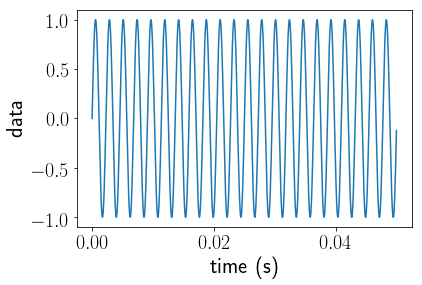

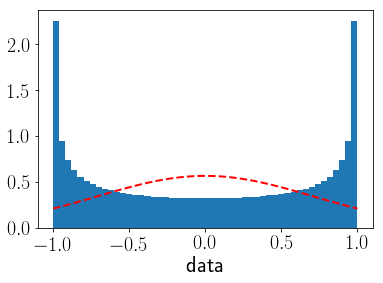

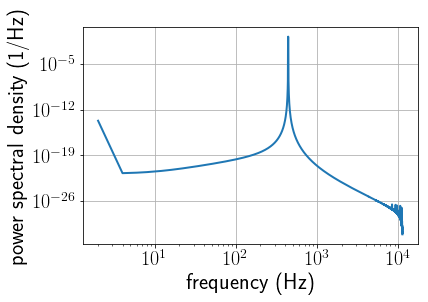

In [6]:
# pure tone
fileprefix = 'puretone'
tmin = 0
tmax = 4.
f0 = 440.
t1 = tmin
t2 = 0.05
Fs = 22500.

t, y = puretone(tmin, tmax, f0)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

# white noise

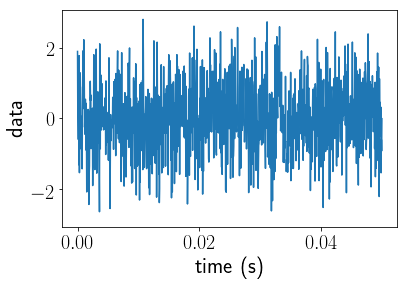

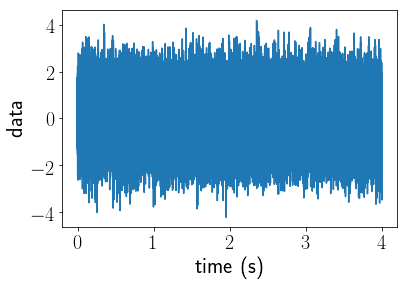

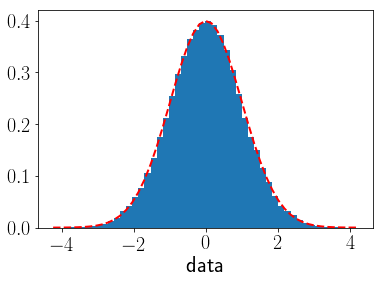

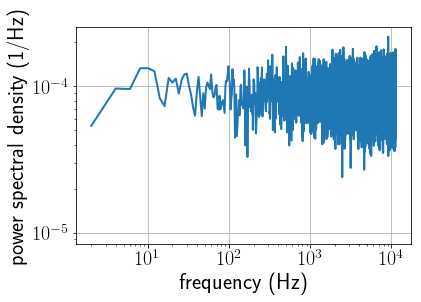

In [7]:
# white noise
random.seed(31459)
fileprefix = 'whitenoise'
tmin = 0
tmax = 4.
var = 1.
t1 = tmin
t2 = 0.05
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, 'whitenoise_zoom')
plottimeseries(t, y, tmin, tmax, fileprefix)
plothistogram(t, y, tmin, tmax, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

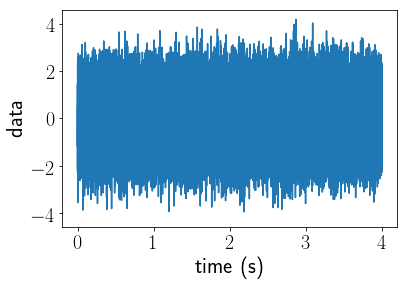

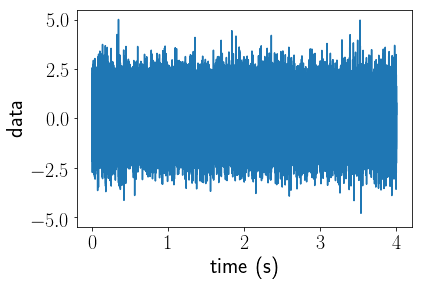

In [8]:
# white noise (two more realizations for two detectors, 4 seconds)
random.seed(1234)
fileprefix = 'whitenoise_det1'
tmin = 0
tmax = 4.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

random.seed(4321)
fileprefix = 'whitenoise_det2'
tmin = 0
tmax = 4.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

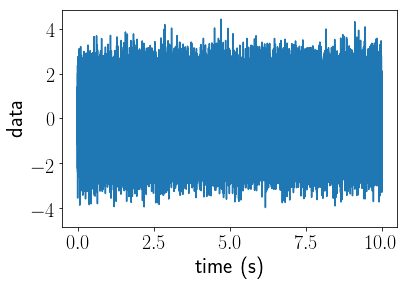

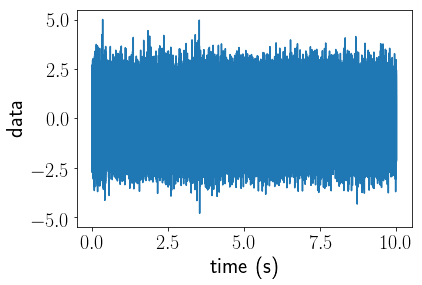

In [9]:
# white noise (two more realizations for two detectors, 10 seconds)
random.seed(1234)
fileprefix = 'whitenoise_det1_10sec'
tmin = 0
tmax = 10.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

random.seed(4321)
fileprefix = 'whitenoise_det2_10sec'
tmin = 0
tmax = 10.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

# BNS chirp signals

chirp duration = 4.84968646913


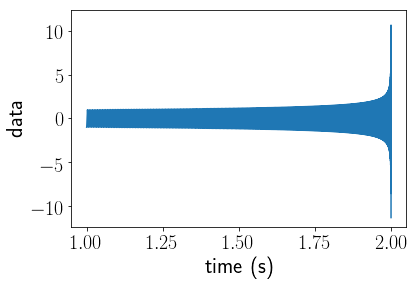

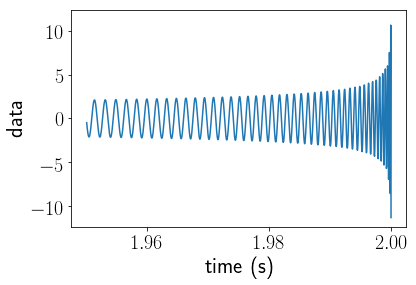

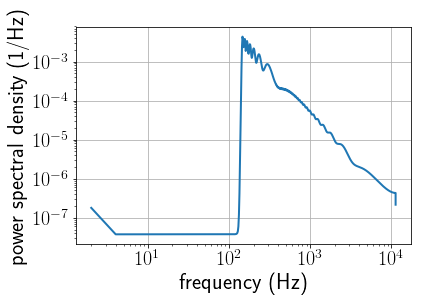

In [10]:
# single BNS chirp
fileprefix = 'chirpBNS'
tmin = 0
tmax = 4.
A = 1
mass = 1.4 # BNS
t0 = 0.5*(tmin+tmax)
fcut = 100.
lambda_poisson = 0
Fs = 22500.

# calculate chirp duration (depends on Mc and fcut)
m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
Mc = m/pow(2,1./5.)     
tau = 1./pow(2.*np.pi*(8./5.)*pow(Mc,5./8.)*fcut,8./3.)
print 'chirp duration =', tau

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t0-1.0, t0, fileprefix)
plottimeseries(t, y, t0-0.05, t0, fileprefix+'_zoom')
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

chirp duration = 4.84968646913


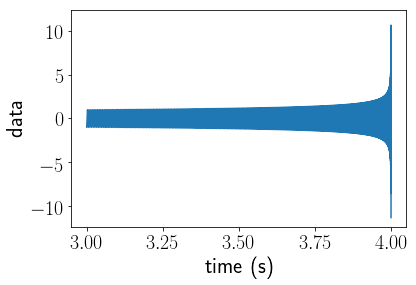

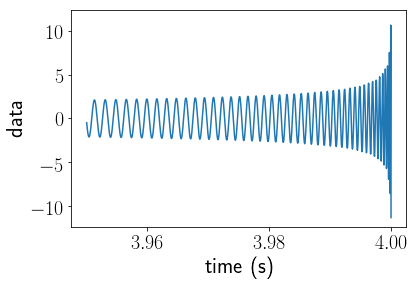

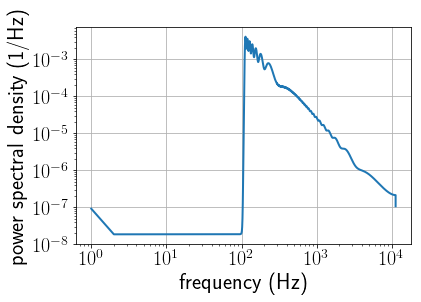

In [11]:
# single BNS chirp (full duration chirp)
fileprefix = 'chirpBNS_full'
tmin = 0
tmax = 8.
A = 1
mass = 1.4 # BNS
t0 = 0.5*(tmin+tmax)
fcut = 100.
lambda_poisson = 0
Fs = 22500.

# calculate chirp duration (depends on Mc and fcut)
m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
Mc = m/pow(2,1./5.)     
tau = 1./pow(2.*np.pi*(8./5.)*pow(Mc,5./8.)*fcut,8./3.)
print 'chirp duration =', tau

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t0-1.0, t0, fileprefix)
plottimeseries(t, y, t0-0.05, t0, fileprefix+'_zoom')
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

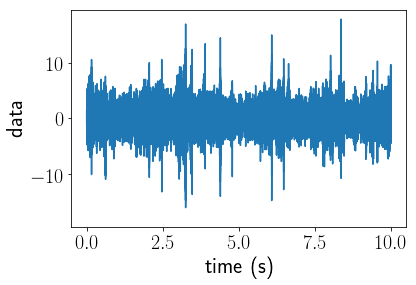

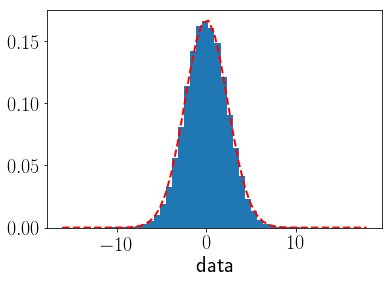

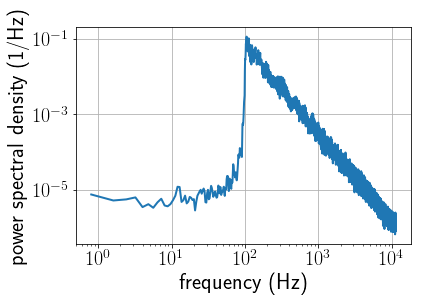

In [12]:
# BNS chirp (25 in 10 sec)
random.seed(31459)
fileprefix = 'chirpBNS25_10s'
tmin = 0
tmax = 10.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 25.
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:np.int(len(tt)/2.)]
y = yy[0:np.int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

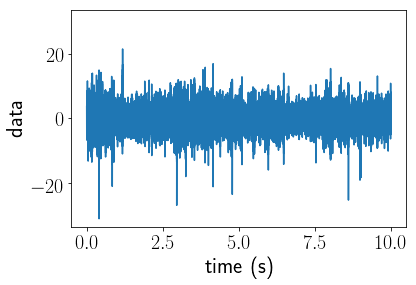

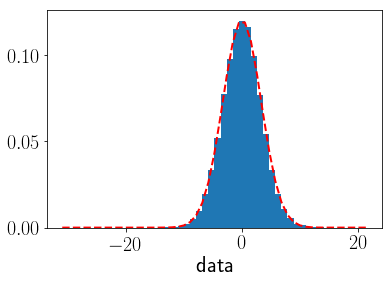

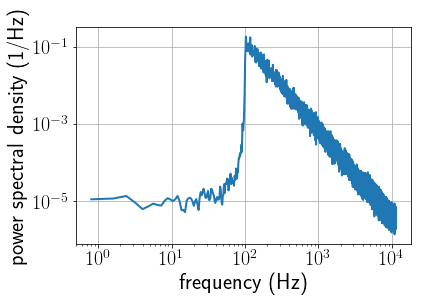

In [13]:
# BNS chirp (50 in 10 sec)
random.seed(31459)
fileprefix = 'chirpBNS50_10s'
tmin = 0
tmax = 10.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 50.
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:np.int(len(tt)/2.)]
y = yy[0:np.int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

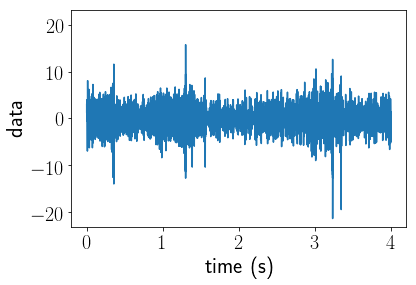

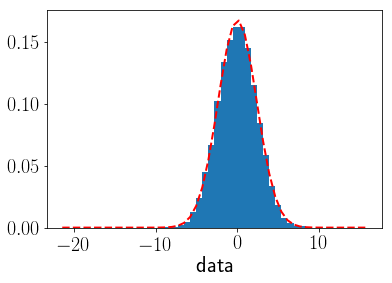

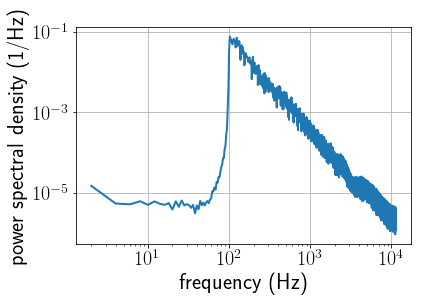

In [14]:
# BNS chirp (10)
random.seed(31459)
fileprefix = 'chirpBNS10'
tmin = 0
tmax = 4.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 10.
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:np.int(len(tt)/2.)]
y = yy[0:np.int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

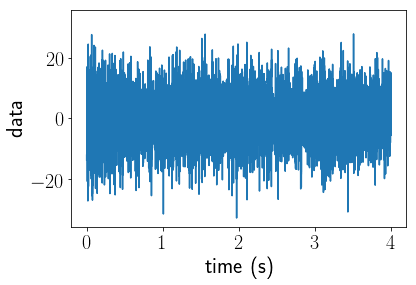

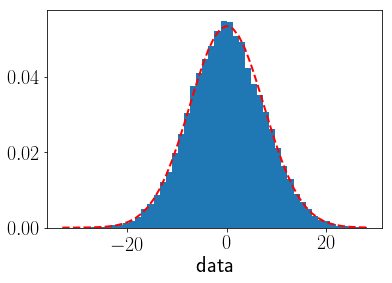

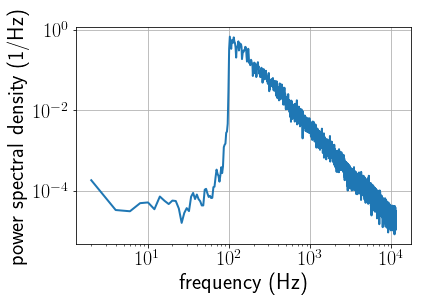

In [15]:
# BNS chirp (100)
random.seed(31459)
fileprefix = 'chirpBNS100'
tmin = 0
tmax = 4.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 100
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:np.int(len(tt)/2.)]
y = yy[0:np.int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

# BBH chirp signals

chirp duration = 0.18306011125


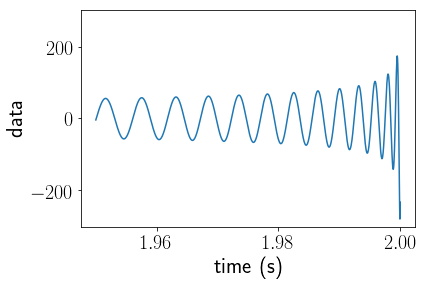

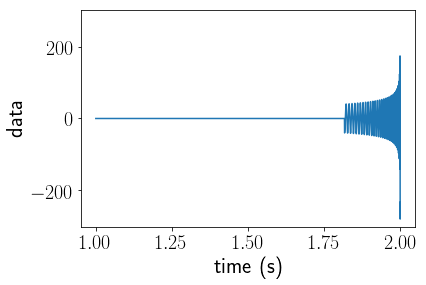

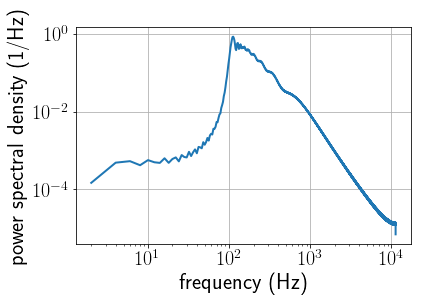

In [16]:
# single BBH chirp
fileprefix = 'chirpBBH'
tmin = 0
tmax = 4.
A = 1.
mass = 10. # BBH
t0 = 0.5*(tmin+tmax)
fcut = 100.
lambda_poisson = 0
Fs = 22500.

# calculate chirp duration (depends on Mc and fcut)
m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
Mc = m/pow(2,1./5.)     
tau = 1./pow(2.*np.pi*(8./5.)*pow(Mc,5./8.)*fcut,8./3.)
print 'chirp duration =', tau

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t0-0.05, t0, fileprefix+'_zoom')
plottimeseries(t, y, t0-1.0, t0, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

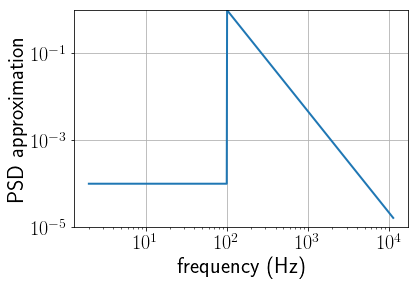

In [17]:
# approximate power spectrum of BBH chirp f0 with a f^{-7/3} spectrum cutoff at f0 (stationary phase)
# NOTE: f^{-7/3} corresponds to Omega_gw ~ f^{2/3} and S_gw = Omega_gw/f^3
f0 = 100.
Fs = 22500.
fNyq = Fs/2.
tmin = 0.
tmax = 4. # max duration of signals

deltaF = 8.*(1./tmax) # multiply by 8 to agree with psd estimation
f = np.linspace(deltaF, fNyq, np.int(Fs/deltaF))

P = 1.e-4*np.ones(len(f))
ndx = np.where(f>=f0)[0]
P[ndx] = 1./pow(f[ndx]/f0,7./3.)

# plot power spectrum
filename = 'stationaryphase.png'
plt.figure()
plt.rc('text', usetex=True)
plt.tick_params(labelsize=20)
plt.loglog(f, P, linewidth=2)
plt.xlabel('frequency (Hz)', size=22)
plt.ylabel('PSD approximation', size=22)
plt.ylim([1e-5, 1])
plt.grid(True)
plt.savefig(filename, bbox_inches='tight', dpi=400)

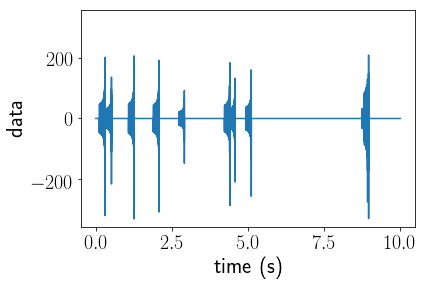

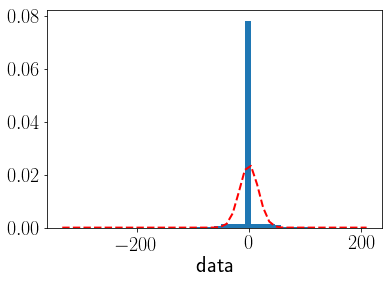

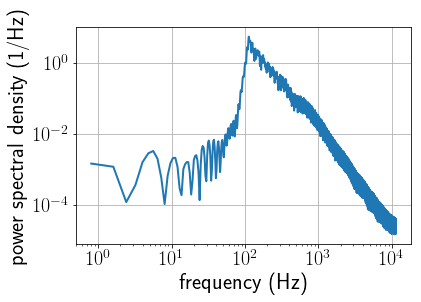

In [18]:
# BBH chirp (10 in 10 sec)
#random.seed(12345)
random.seed(3)
fileprefix = 'chirpBBH10_10s'
tmin = 0
tmax = 10.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 10.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

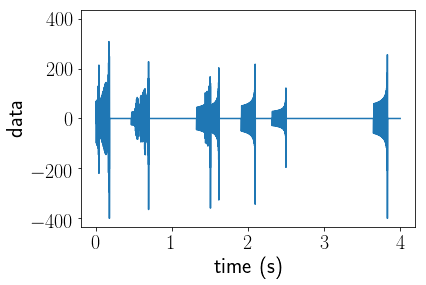

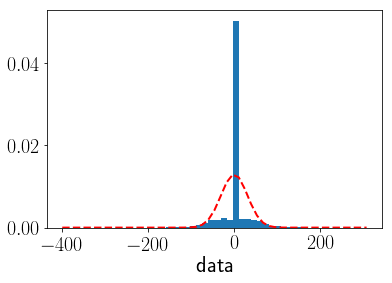

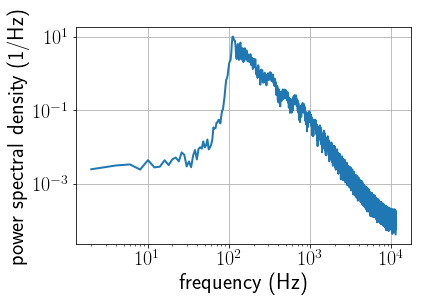

In [19]:
# BBH chirp (10)
random.seed(31459)
fileprefix = 'chirpBBH10'
tmin = 0
tmax = 4.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 10.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

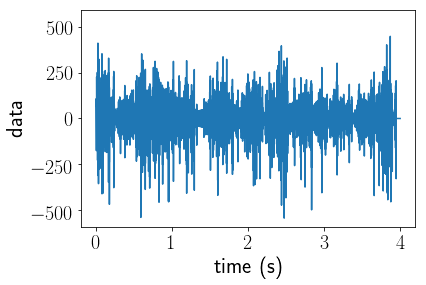

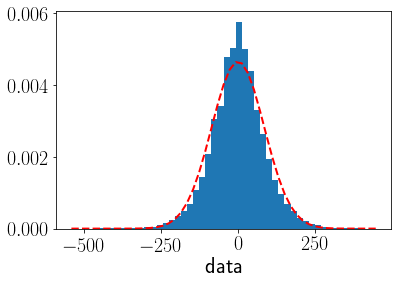

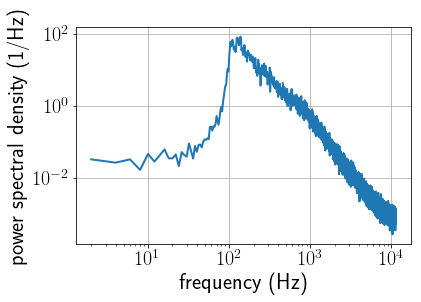

In [20]:
# BBH chirp (100)
random.seed(31459)
fileprefix = 'chirpBBH100'
tmin = 0
tmax = 4.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 100.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

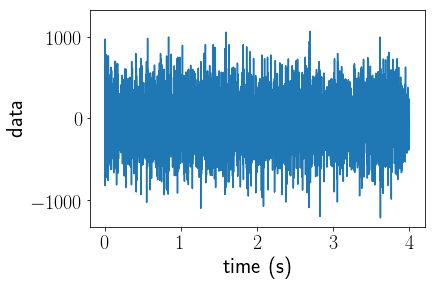

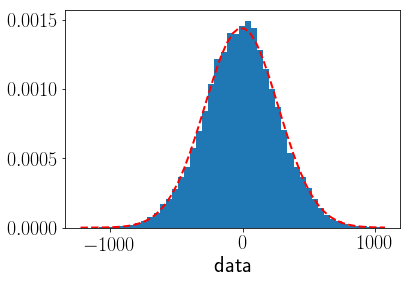

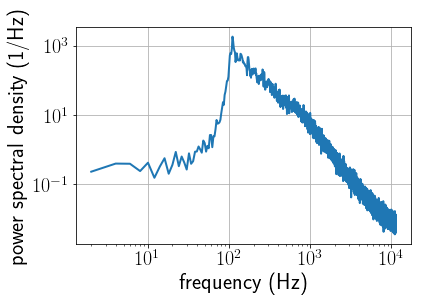

In [21]:
# BBH chirp (1000)
random.seed(31459)
fileprefix = 'chirpBBH1000'
tmin = 0
tmax = 4.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 1000.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

# ringdown signals

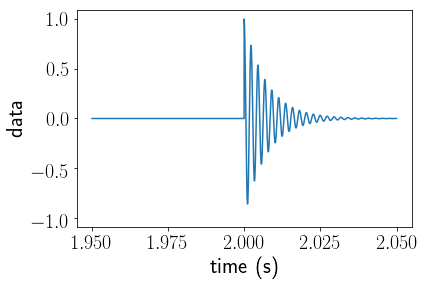

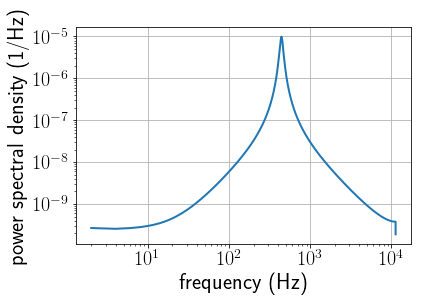

In [22]:
# single ringdown
fileprefix = 'ringdown'
tmin = 0
tmax = 4.
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 0
t0 = 2
t1 = t0-0.05
t2 = t0+0.05
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

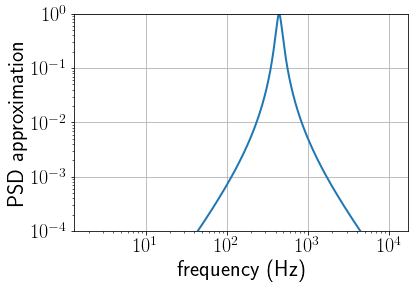

In [23]:
# approximate power spectrum of ringdown (f0, Q) a lorentzian
f0 = 440.
Q = 20. 
Fs = 22500.
fNyq = Fs/2.
tmin = 0.
tmax = 4. # max duration of signals

deltaF = 8.*(1./tmax) # multiply by 8 to agree with psd estimation
f = np.linspace(deltaF, fNyq, np.int(Fs/deltaF))

w = 2.*Q # width parameter
L = (w**2.)/((f-f0)**2 + w**2) # normalized to 1
ndx = np.where(f<f0)[0]
L[ndx]=((f[ndx]/f0)**2)*L[ndx]

# plot power spectrum
filename = 'lorentzian.png'
plt.figure()
plt.rc('text', usetex=True)
plt.tick_params(labelsize=20)
plt.loglog(f, L, linewidth=2)
plt.xlabel('frequency (Hz)', size=22)
plt.ylabel('PSD approximation', size=22)
plt.ylim([1e-4, 1])
plt.grid(True)
plt.savefig(filename, bbox_inches='tight', dpi=400)

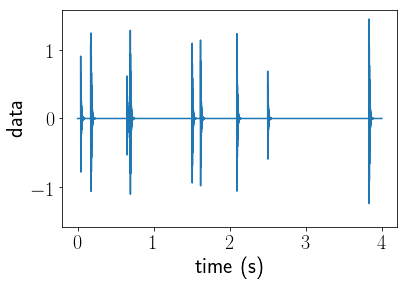

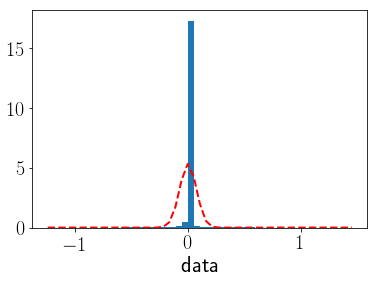

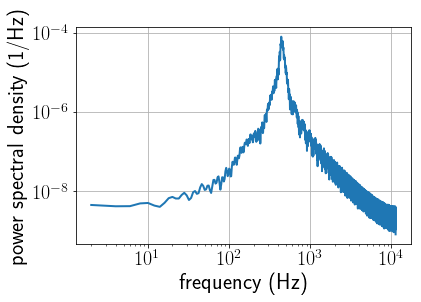

In [24]:
# ringdown (10)
random.seed(31459)
fileprefix = 'ringdown10'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 10
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix) 
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

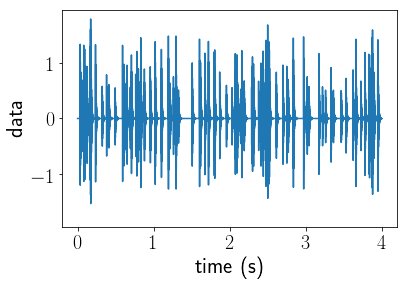

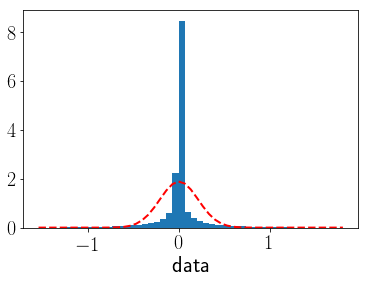

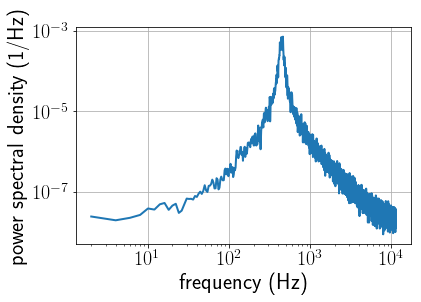

In [25]:
# ringdown (100)
random.seed(31459)
fileprefix = 'ringdown100'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 100
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)  
plothistogram(t, y, t1, t2, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

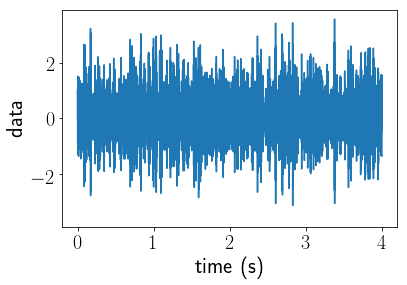

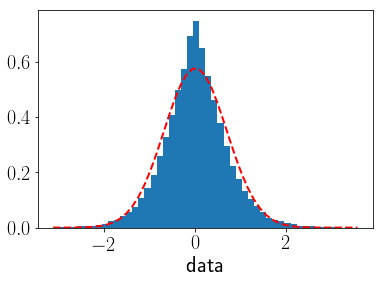

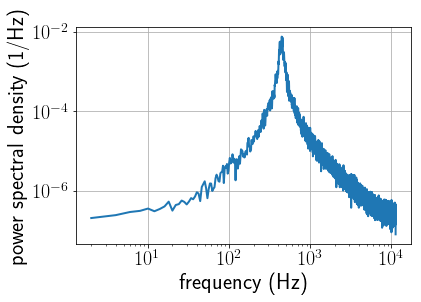

In [26]:
# ringdown (1000)
random.seed(31459)
fileprefix = 'ringdown1000'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 1000
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)  
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

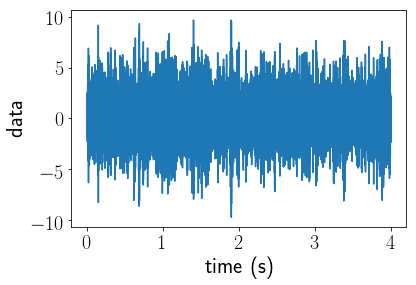

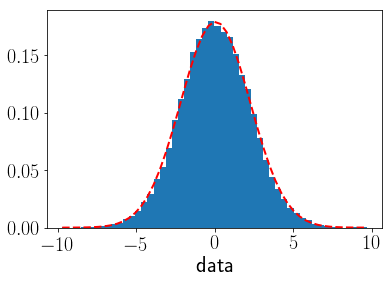

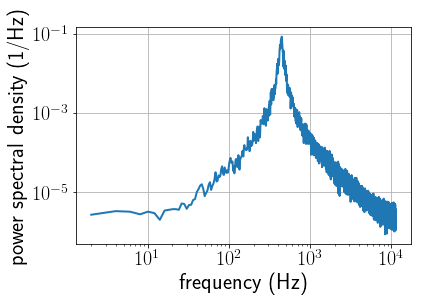

In [27]:
# ringdown (10000)
random.seed(31459)
fileprefix = 'ringdown10000'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 10000
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsound(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)  
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)